In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal
from scipy import ndimage
import ncc
import matplotlib.pyplot as plt

In [ ]:
def MakeGaussianPyramid(image, scale, minsize):
  sigma = 1/(2*scale)
  pyramid = []
  pyramid.append(np.asarray(image))
  if pyramid[0].shape[-1] == 3:
    sigma = (sigma,sigma,0)
  x,y = image.size
  curr = image
  while math.floor(max((x,y))*0.75) > minsize:
    # make it image type so i can use the resize function
    curr = Image.fromarray(ndimage.gaussian_filter(pyramid[-1], sigma).astype('uint8'))
    x = int(pyramid[-1].shape[1]*scale)
    y = int(pyramid[-1].shape[0]*scale)
    pyramid.append(np.asarray(curr.resize((x,y), Image.BICUBIC), 'float'))
  return np.array(pyramid)


(119, 189)


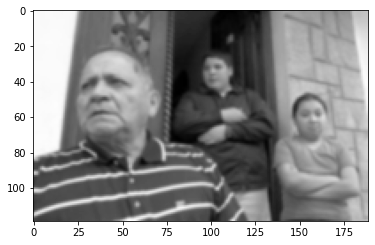

(159, 252)


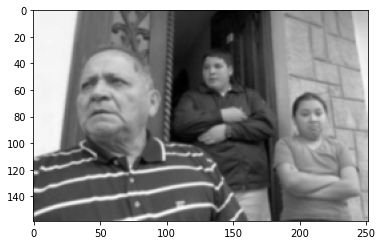

(213, 336)


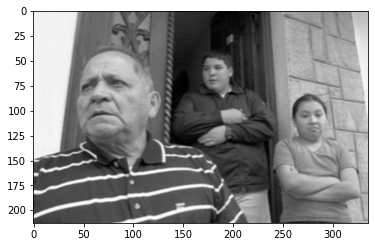

(285, 449)


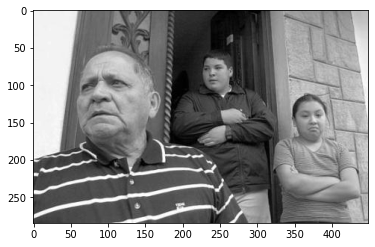

In [ ]:
# testing it:
family_orig = Image.open('family.jpg')
pyr = MakeGaussianPyramid(family_orig, 0.75, 150)
plt.gray() 

print(pyr[3].shape)
plt.imshow(pyr[3])
plt.show()

print(pyr[2].shape)
plt.imshow(pyr[2])
plt.show()

print(pyr[1].shape)
plt.imshow(pyr[1])
plt.show()

print(pyr[0].shape)
plt.imshow(pyr[0])

In [ ]:
def ShowGaussianPyramid(pyramid):
  height = pyramid[0].shape[0]
  width = 0
  for i in pyramid: 
    width += i.shape[1]
  im = Image.new("RGB", (width, height),(255, 255, 255))
  offset_x = 0; offset_y = 0;
  for curr in pyramid:
    im.paste(Image.fromarray(curr.astype('uint8')),(offset_x,offset_y))
    offset_x += curr.shape[1] 
  plt.figure(figsize=(10,10))
  plt.imshow(im)
  plt.show()

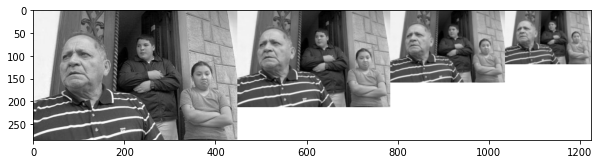

In [ ]:
# testing:
ShowGaussianPyramid(pyr)

In [ ]:
def FindTemplate(pyramid, template, threshold):
  twidth_orig = template.size[0]; theight_orig = template.size[1]
  twidth = 15
  theight = round(twidth*theight_orig/twidth_orig)
  temp_resize = template.resize((twidth, theight), Image.BICUBIC)
  orig = Image.fromarray(pyramid[0].astype('uint8')).convert('RGB')
  power = 1
  draw = ImageDraw.Draw(orig)
  for i, im in enumerate(pyramid):
    correlation = ncc.normxcorr2D(im, temp_resize)
    matches = np.argwhere(correlation > threshold)
    for m in matches:
      location = np.divide(m, power)
      y_top = location[0]-math.floor(theight_orig/2)
      y_bot = location[0]+math.ceil(theight_orig/2)
      x_l = location[1]-math.floor(twidth_orig/2)
      x_r = location[1]+math.ceil(twidth_orig/2)
      # print(y_top, y_bot, x_l, x_r)
      draw.line((x_l,y_top,x_r,y_top), fill='red', width=1) # top line
      draw.line((x_l,y_top,x_l,y_bot), fill='red', width=1) # left line
      draw.line((x_r,y_top,x_r,y_bot), fill='red', width=1) # right line
      draw.line((x_l,y_bot,x_r,y_bot), fill='red', width=1) # bottom line
    power = power*0.75
  plt.imshow(orig)
  plt.show()

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


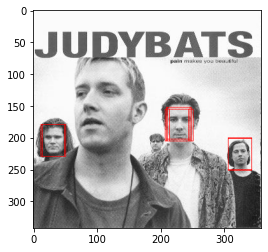

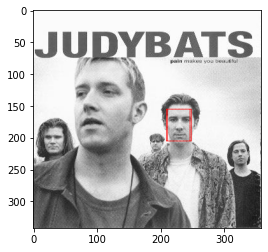

In [ ]:
#testing:
template = Image.open('template.jpg')
judybats = Image.open('judybats.jpg')

FindTemplate(MakeGaussianPyramid(judybats, 0.75, 100), template, 0.7)
FindTemplate(MakeGaussianPyramid(judybats, 0.75, 100), template, 0.8)

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


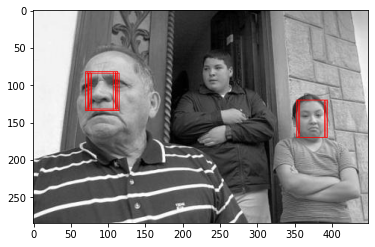

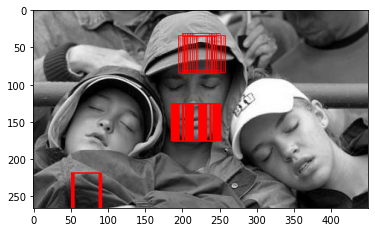

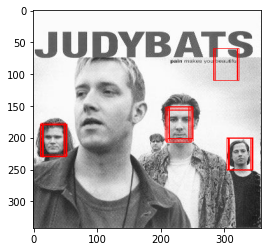

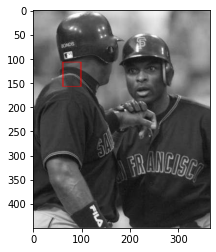

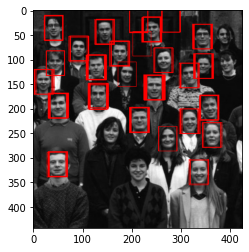

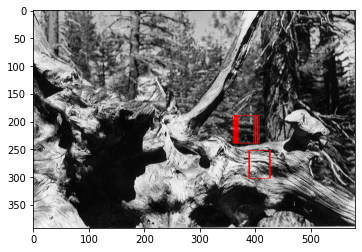

In [ ]:
template = Image.open('template.jpg')
family = Image.open('family.jpg')
fans = Image.open('fans.jpg')
judybats = Image.open('judybats.jpg')
sports = Image.open('sports.jpg')
students = Image.open('students.jpg')
tree = Image.open('tree.jpg')

thres = 0.58
FindTemplate(MakeGaussianPyramid(family, 0.75, 100), template, thres)
FindTemplate(MakeGaussianPyramid(fans, 0.75, 100), template, thres)
FindTemplate(MakeGaussianPyramid(judybats, 0.75, 100), template, thres)
FindTemplate(MakeGaussianPyramid(sports, 0.75, 100), template, thres)
FindTemplate(MakeGaussianPyramid(students, 0.75, 100), template, thres)
FindTemplate(MakeGaussianPyramid(tree, 0.75, 100), template, thres)


In [ ]:
def MakeLaplacianPyramid(image, scale, minsize):
  sigma = 1/(2*scale)
  gpyr = MakeGaussianPyramid(image, scale, minsize)
  laplace = []
  for i in gpyr[:-1]:
    i = np.asarray(i, 'float')
    r = np.subtract(i[:,:,0], ndimage.gaussian_filter(i[:,:,0], sigma))
    g = i[:,:,1] - ndimage.gaussian_filter(i[:,:,1], sigma)
    b = i[:,:,2] - ndimage.gaussian_filter(i[:,:,2], sigma)
    laplace.append(np.dstack((r,g,b)))
  laplace.append(gpyr[-1])
  return np.array(laplace)

orchid = Image.open('orchid.jpg')
lpyr_or = MakeLaplacianPyramid(orchid, 0.75, 100)

violet = Image.open('violet.jpg')
lpyr_vi = MakeLaplacianPyramid(violet, 0.75, 100)

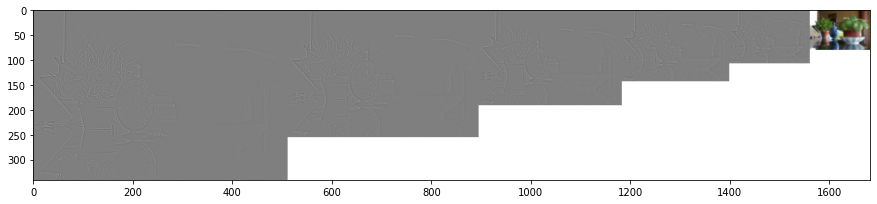

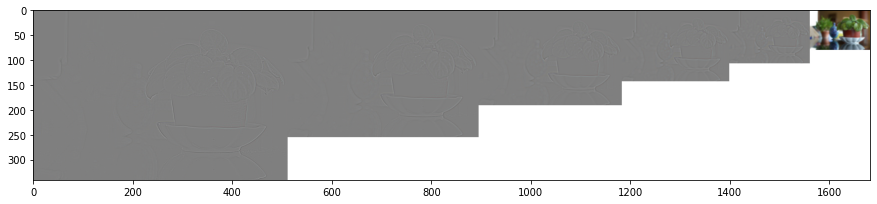

In [ ]:
def ShowLaplacianPyramid(pyramid):
  height = pyramid[0].shape[0]
  width = 0
  for i in pyramid:
    width += i.shape[1]
  im = Image.new("RGB", (width, height), (255,255,255))
  offset_x = 0; offset_y = 0;
  for curr in pyramid[:-1]:
    im.paste(Image.fromarray(np.clip(curr+128, 0, 255).astype('uint8')), (offset_x, offset_y))
    # plt.imshow(Image.fromarray(np.clip(curr+128, 0, 255).astype('uint8')))
    # plt.show()
    offset_x += curr.shape[1]
  im.paste(Image.fromarray(pyramid[-1].astype('uint8')), (offset_x, offset_y))
  plt.figure(figsize=(15,15))
  plt.imshow(im)
  plt.show()
ShowLaplacianPyramid(lpyr_or)
ShowLaplacianPyramid(lpyr_vi)

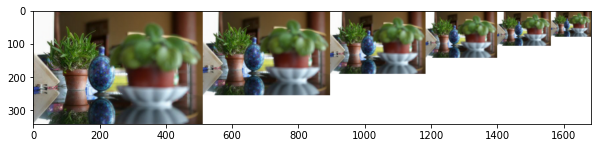

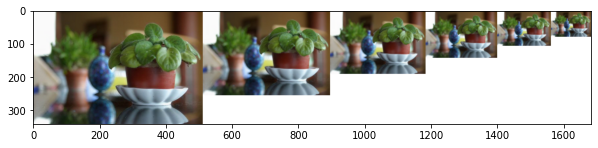

In [ ]:
def ReconstructGaussianFromLaplacianPyramid(lPyramid):
  scale = 0.75
  gpyr = [lPyramid[-1]]
  prev = lPyramid[-1]
  for idx,im in enumerate(reversed(lPyramid[:-1])):
    curr = Image.fromarray(prev.astype('uint8')).resize((im.shape[1], im.shape[0]), Image.BICUBIC)
    # curr = np.asarray(curr, 'float')
    # plt.imshow(curr)
    # plt.show()
    gpyr.append(np.clip(np.asarray(curr + im, 'float'),0,255))
    prev = gpyr[-1]
  gpyr.reverse()
  return np.asarray(gpyr)
  
recons_orchid = ReconstructGaussianFromLaplacianPyramid(lpyr_or)
ShowGaussianPyramid(recons_orchid)
recons_violet = ReconstructGaussianFromLaplacianPyramid(lpyr_vi)
ShowGaussianPyramid(recons_violet)


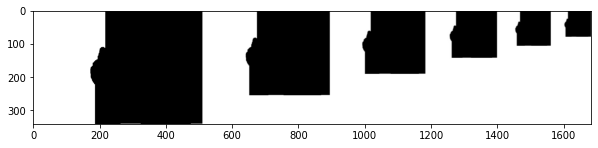

In [ ]:
orchid_mask = Image.open('orchid_mask.bmp')
gpyr_orchid_mask = MakeGaussianPyramid(orchid_mask, 0.75, 100)
ShowGaussianPyramid(gpyr_orchid_mask)

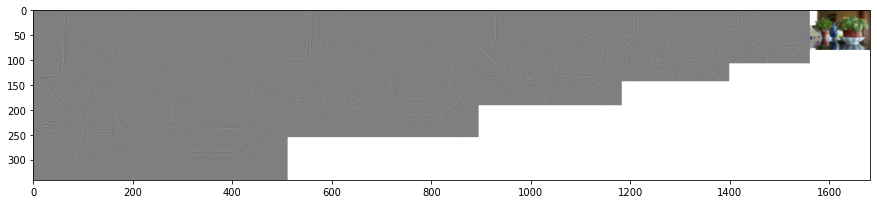

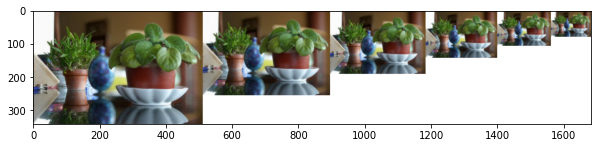

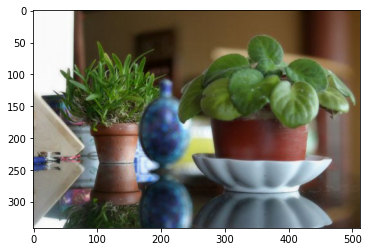

In [ ]:
lpyr_or = MakeLaplacianPyramid(orchid, 0.75, 100)
lpyr_vi = MakeLaplacianPyramid(violet, 0.75, 100)

compLaplacian = []
for i in range(len(lpyr_or)):
  r = lpyr_or[i][:,:,0] * gpyr_orchid_mask[i]/255 +  lpyr_vi[i][:,:,0] * (1 - gpyr_orchid_mask[i]/255)
  g = lpyr_or[i][:,:,1] * gpyr_orchid_mask[i]/255 +  lpyr_vi[i][:,:,1] * (1 - gpyr_orchid_mask[i]/255)
  b = lpyr_or[i][:,:,2] * gpyr_orchid_mask[i]/255 +  lpyr_vi[i][:,:,2] * (1 - gpyr_orchid_mask[i]/255)
  temp = np.dstack((r,g,b))
  compLaplacian.append(temp)


ShowLaplacianPyramid(compLaplacian)
recons_comp = ReconstructGaussianFromLaplacianPyramid(compLaplacian)
ShowGaussianPyramid(recons_comp)
plt.imshow(recons_comp[0].astype('uint8'))

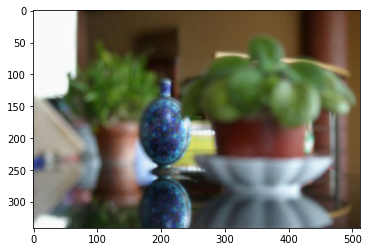

In [ ]:
def ComposeLaplacian(lapA, lapB, gaussianM): # I wrote a function for it after testing it out and seeing how it works
  comp = []
  for i in range(len(lapA)):
    r = lapA[i][:,:,0] * gaussianM[i]/255 +  lapB[i][:,:,0] * (1 - gaussianM[i]/255)
    g = lapA[i][:,:,1] * gaussianM[i]/255 +  lapB[i][:,:,1] * (1 - gaussianM[i]/255)
    b = lapA[i][:,:,2] * gaussianM[i]/255 +  lapB[i][:,:,2] * (1 - gaussianM[i]/255)
    temp = np.dstack((r,g,b))
    comp.append(temp)
  return comp

comp = ComposeLaplacian(lpyr_vi, lpyr_or, gpyr_orchid_mask)
plt.imshow(ReconstructGaussianFromLaplacianPyramid(comp)[0].astype('uint8'))

In [ ]:
blue_cup = Image.open('blue_cup.jpg')
green_cup = Image.open('green_cup.jpg')
mask_cup = Image.open('cup_mask.bmp')
apple = Image.open('apple.jpg')
tomato = Image.open('tomato.jpg')
tomato_mask = Image.open('tomato_mask.bmp')

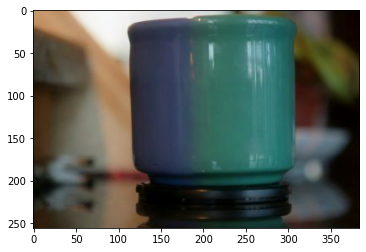

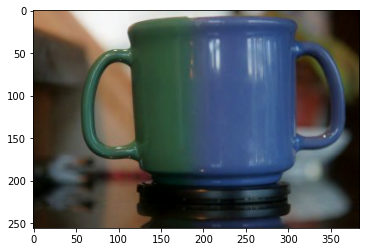

In [ ]:
# blue and green cup
lpyr_blue = MakeLaplacianPyramid(blue_cup, 0.75, 25)
lpyr_green = MakeLaplacianPyramid(green_cup, 0.75, 25)
gpyr_mask = MakeGaussianPyramid(mask_cup, 0.75, 25)

comp = ComposeLaplacian(lpyr_blue, lpyr_green, gpyr_mask)
plt.imshow(ReconstructGaussianFromLaplacianPyramid(comp)[0].astype('uint8'))
plt.show()

comp = ComposeLaplacian(lpyr_green, lpyr_blue, gpyr_mask)
plt.imshow(ReconstructGaussianFromLaplacianPyramid(comp)[0].astype('uint8'))

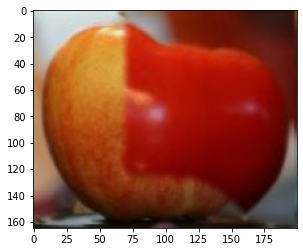

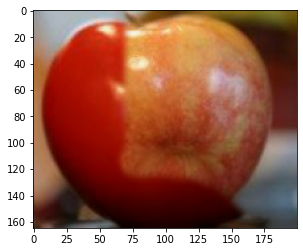

In [ ]:
# apple and tomato, the line seems harsh
lpyr_apple = MakeLaplacianPyramid(apple, 0.75, 50)
lpyr_tomato = MakeLaplacianPyramid(tomato, 0.75, 50)
gpyr_mask = MakeGaussianPyramid(tomato_mask, 0.75, 50)

comp = ComposeLaplacian(lpyr_apple, lpyr_tomato, gpyr_mask)
plt.imshow(ReconstructGaussianFromLaplacianPyramid(comp)[0].astype('uint8'))
plt.show()

comp = ComposeLaplacian(lpyr_tomato, lpyr_apple, gpyr_mask)
plt.imshow(ReconstructGaussianFromLaplacianPyramid(comp)[0].astype('uint8'))

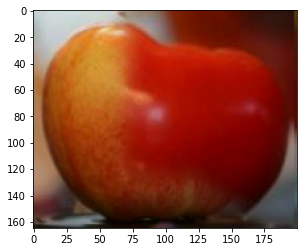

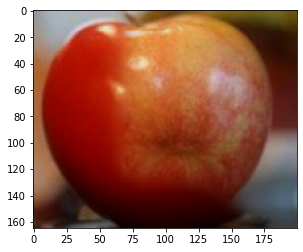

In [ ]:
# making a deeper laplacian and gaussian makes the blend to be more seamless
lpyr_apple = MakeLaplacianPyramid(apple, 0.75, 15)
lpyr_tomato = MakeLaplacianPyramid(tomato, 0.75, 15)
gpyr_mask = MakeGaussianPyramid(tomato_mask, 0.75, 15)

comp = ComposeLaplacian(lpyr_apple, lpyr_tomato, gpyr_mask)
plt.imshow(ReconstructGaussianFromLaplacianPyramid(comp)[0].astype('uint8'))
plt.show()

comp = ComposeLaplacian(lpyr_tomato, lpyr_apple, gpyr_mask)
plt.imshow(ReconstructGaussianFromLaplacianPyramid(comp)[0].astype('uint8'))